# Quiz 1 : Classification task with CNN & BiLSTM

In [1]:
enter_name = "Minn Banya"

In [2]:
import pandas as pd
import torch, torchdata, torchtext
from torch import nn
import time
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 2422
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

C:\Users\minnb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
torch.__version__

'2.1.0+cu121'

In [4]:
torchtext.__version__

'0.16.2+cpu'

## Load the given dataset

1. Create a variable to your dataset PATH *example:  ./data/*
2. Load the csv files using pandas 



In [5]:
DATA_PATH = "./data/"

train_data_raw = pd.read_csv(DATA_PATH + "train.csv")
test_data_raw = pd.read_csv(DATA_PATH + "test.csv")


In [6]:
train_data_raw.shape

(7613, 5)

In [7]:
test_data_raw.shape

(3263, 4)

In [8]:
## Lets analyze the data a little

#print and show how many unique classes are in the target

classes = train_data_raw['target'].unique()
num_classes = len(classes)
print(num_classes)

2


In [9]:
assert num_classes > 1

In [10]:
##lets see how many columns are there
#print the columns of the train_data_raw

print(train_data_raw.columns) #write your code here

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


1. Lets remove the keywords and location columns. We only want to focus on the text and the predictions
2. Lets split some training data to validation dataset

In [11]:
SPLIT_PER = 2 #percentage of split for validation set 2 = 2%
split =  int(len(train_data_raw) * (SPLIT_PER/100))

dropped_train = train_data_raw.drop(columns=['id', 'keyword', 'location']) #drop the id, keyowrd and location columns from the train_data_raw

train_data = dropped_train[:-split]
valid_data = dropped_train[-split:]

assert train_data.shape == (len(train_data_raw) - split, 2)
assert valid_data.shape == (split, 2)

In [12]:
print(train_data_raw.shape)
print("After dropping columns and spliting!")
print(train_data.shape, valid_data.shape)

(7613, 5)
After dropping columns and spliting!
(7461, 2) (152, 2)


## Lets tokenize the data

In [13]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
 
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

In [14]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):
    #loop through the data_iter, 
    # Mind that the data_iter in this case is pandas Dataframe
    for i in range(len(data_iter)):
        yield tokenizer(data_iter['text'][i])

specials = ['<unk>', '<pad>', '<bos>', '<eos>'] #create array of special tags for the vocab
vocab  = build_vocab_from_iterator(yield_tokens(train_data), specials = specials, special_first=True)

#set_default_index of the vocab to unknown tag
vocab.set_default_index(vocab["<unk>"])


In [15]:
assert len(vocab) == 26442

In [16]:
vocab_dict = vocab.get_stoi()
vocab_dict

{'bells': 17043,
 'Escaping': 12472,
 'charge': 2966,
 "'m": 59,
 'putin': 24713,
 'adoption': 6850,
 'STILL': 6529,
 'WOUNDS': 16371,
 'Mafia': 6212,
 'mass': 200,
 'Lubbock': 6184,
 'Gillibrand': 12913,
 'Scarlet': 15416,
 'depreciations': 17800,
 'Bomb': 1013,
 '@WoundedPigeon': 9949,
 'lvl': 23796,
 'advice': 16695,
 '.': 6,
 'restore': 3119,
 'dominant': 17956,
 'thunder': 475,
 '.@NorwayMFA': 8190,
 'pitch': 3866,
 '@9NewsBrisbane': 8744,
 'Odell': 14460,
 'Quarantine': 761,
 'point': 1142,
 '@ByTorrecilla': 8925,
 'fruit': 3025,
 'Some': 319,
 '&': 38,
 '@charstevens97': 10132,
 'http://t.co/JlzK2HdeTG': 7409,
 'Officer': 1265,
 'LLF': 6136,
 'WYOU': 16392,
 'US': 245,
 '...': 18,
 '@SCynic1': 9707,
 'WIN': 16358,
 'appropriation': 6878,
 'Join': 2411,
 '<bos>': 2,
 'illegal': 2239,
 'threat': 1818,
 'Zhejiang': 16615,
 'en\x89Û': 7222,
 'asswipe': 16889,
 'Reactor': 2454,
 '<unk>': 0,
 'suspect': 749,
 'Andrea': 11042,
 'Minority': 4427,
 'illusion': 23303,
 'http://t.co/0wbEcd

In [17]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') ##Load fasttext with language=simple

In [18]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)

#since the fasttext  has 300 embedding
assert fast_embedding.shape == (len(vocab), 300)

In [19]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) ## Copy from the lab. Note that Something has to be changed

In [20]:
text_pipeline("I love to play football")

[13, 185, 10, 683, 2229]

In [21]:
label_pipeline('0')

0

## To fit the padnas dataframe to DataLoader first we must wrap it as DataSet

In [22]:
from torch.utils.data import Dataset

class PD_DATASET(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]

In [23]:
# Reset validation index to fix index error during collate_batch
valid_data = valid_data.reset_index()
valid_data = valid_data.drop(columns='index')

In [24]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)
test = PD_DATASET(test_data_raw)

In [25]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] ##get the pad index from the vocab

def collate_batch(batch):
    ## copy the collate_batch function from Professor's code. But it will not work right away
    #mind how the dataset that we use is structured (hint: columns)
    label_list, text_list, length_list = [], [], []
    for i in range(len(batch)):
        label_list.append(label_pipeline(batch[i]['target']))
        processed_text = torch.tensor(text_pipeline(batch[i]['text']), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list, padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

In [26]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)

In [27]:
next(iter(train_loader))

(tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]),
 tensor([[  927,  1891,   298,  ...,     1,     1,     1],
         [ 1606,   480,  1373,  ...,     1,     1,     1],
         [    4, 11448,  7141,  ...,     1,     1,     1],
         ...,
         [  106, 17820, 17901,  ...,     1,     1,     1],
         [    4, 25073,  1078,  ...,     1,     1,     1],
         [   45, 25530,  1442,  ...,     1,     1,     1]]),
 tensor([13, 21, 21, 23, 21, 16, 19, 13, 27, 20, 12, 13, 12, 28, 18, 30, 20,  8,
         14, 17, 15, 21, 15, 31, 22, 24, 20, 22,  7, 21, 18, 23, 13, 45,  2, 20,
         12, 27, 14, 12, 21, 12, 19, 13, 13,  3, 19, 31, 15, 24, 32, 20, 12, 12,
         17, 11, 18,  9,  8, 23, 21, 22, 19, 26]))

In [28]:
for label, text, length in train_loader:
    break

print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 36])


## First lets try CNN

In [29]:
import torch.nn as nn
import torch.nn.functional as F

## Get the Professor's code from  the lab to build the CNN model

class CNN(nn.Module):
    def __init__(self, input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes):
        
        super().__init__()
                
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, emb_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [30]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) 

In [31]:
input_dim  = len(vocab)
emb_dim    =  300 #how many embedding does the fasttext have 
output_dim =  2 #how many classes do we have
dropout    = 0.5
n_filters  = 100 
filter_sizes = [3, 4, 5]

cnn_model = CNN(input_dim, emb_dim, output_dim, dropout, n_filters, filter_sizes).to(device)
cnn_model.apply(initialize_weights) #apply initialize_weight
cnn_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [32]:
batch_size = 3
seq_len    = 50 

In [33]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.SGD(cnn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [34]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [35]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [36]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate 
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [37]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
best_valid_loss = float('inf')
num_epochs      = 5

save_path = f'./models/{cnn_model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

total_start_time = time.time()

for epoch in range(num_epochs):
        #write the code that starts the training, store the training and valid losses and accuracy
    start_time = time.time()

    train_loss, train_acc = train(cnn_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(cnn_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    #also print the time it took to train the model

total_end_time = time.time()
total_mins, total_secs = epoch_time(total_start_time, total_end_time)
print(f'Total Time: {total_mins}m {total_secs}s')

Epoch: 01 | Time: 0m 2s
	Train Loss: 0.836 | Train Acc: 48.51%
	 Val. Loss: 0.738 |  Val. Acc: 42.53%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.778 | Train Acc: 52.55%
	 Val. Loss: 0.720 |  Val. Acc: 43.06%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.767 | Train Acc: 52.28%
	 Val. Loss: 0.704 |  Val. Acc: 47.22%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.755 | Train Acc: 53.72%
	 Val. Loss: 0.703 |  Val. Acc: 45.14%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.738 | Train Acc: 54.64%
	 Val. Loss: 0.691 |  Val. Acc: 48.78%
Total Time: 0m 11s


Text(0, 0.5, 'loss')

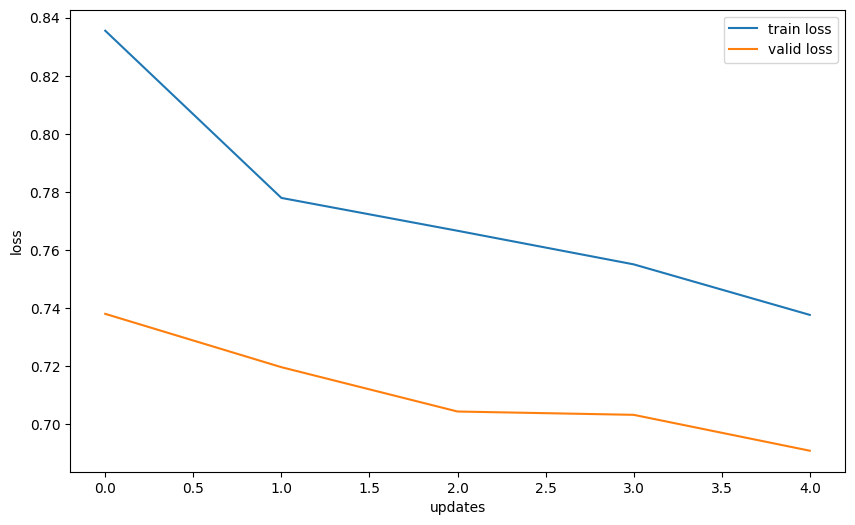

In [40]:
##Plot the training loss and the accuracy
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

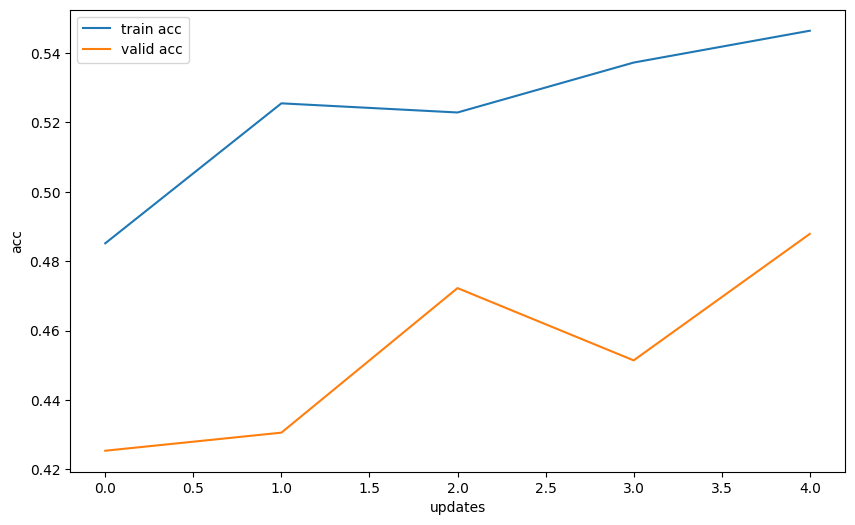

In [41]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

# Lets Try the LSTM model

In [42]:
train = PD_DATASET(train_data)
valid = PD_DATASET(valid_data)

In [43]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, num_layers, 
                 bidirectional, dropout, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm      = nn.LSTM(
                            emb_dim,
                            hid_dim,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            dropout = dropout,
                            batch_first = True
                        )
        self.fc        = nn.Linear(hid_dim * 2, output_dim)
    
    def forward(self, text, text_length):
        #text = [batch_size, seq len]
        embedded = self.embedding(text)
        #text = [batch_size, seq len, emb_dim]
        
        #pack sequence 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_length.to('cpu'), 
                                                            enforce_sorted=False, batch_first=True)
        
        packed_output, (hn, cn) = self.lstm(packed_embedded)
        #output is basically all the hidden states;  hn is only last hidden state; cn is last cell state
        
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        #output = [batch_size, seq len, hidden_dim * num directions]
        #hn     = [num_layers * num_directions, batch_size,  hid_dim]  #3 layers birectional - hn1f, hn1b, hn2f, hn2b, hn3f, hn3b
        #cn     = [num_layers * num_directions, batch_size,  hid_dim]
        
        hn      = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim = 1)
        #hn     = [batch_size, hidden_dim * num_directions]
        
        return self.fc(hn)

In [44]:
input_dim  = len(vocab)
emb_dim    = 300 #same as above
hidden_dim = 256 #how many hidden dims do you want?
output_dim = 2 #same as above
dropout    = 0.5
num_layers = 2
bidirectional = True 

lstm_model = LSTM(input_dim, emb_dim, hidden_dim, num_layers, bidirectional, dropout, output_dim).to(device)
lstm_model.apply(initialize_weights) #apply initialize_weight
lstm_model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [45]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(lstm_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #

In [46]:
def train(model, loader, optimizer, criterion, loader_length):
    #write the code to train the model
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = model(text).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [47]:
def evaluate(model, loader, criterion, loader_length):
    #write the code to evaluate the model
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [48]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
best_valid_loss = float('inf')
num_epochs   = 5

save_path = f'./models/lstm_{lstm_model.__class__.__name__}.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

total_start_time = time.time()

for epoch in range(num_epochs):
    #write the code that starts the training, store the training and valid losses and accuracy
    #also print the time it took to train the model
    start_time = time.time()

    train_loss, train_acc = train(cnn_model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(cnn_model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(cnn_model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    #also print the time it took to train the model

total_end_time = time.time()
total_mins, total_secs = epoch_time(total_start_time, total_end_time)
print(f'Total Time: {total_mins}m {total_secs}s')

Epoch: 01 | Time: 0m 2s
	Train Loss: 0.734 | Train Acc: 55.48%
	 Val. Loss: 0.690 |  Val. Acc: 49.65%
Epoch: 02 | Time: 0m 2s
	Train Loss: 0.735 | Train Acc: 55.44%
	 Val. Loss: 0.710 |  Val. Acc: 44.44%
Epoch: 03 | Time: 0m 2s
	Train Loss: 0.734 | Train Acc: 55.08%
	 Val. Loss: 0.694 |  Val. Acc: 47.92%
Epoch: 04 | Time: 0m 2s
	Train Loss: 0.735 | Train Acc: 55.30%
	 Val. Loss: 0.706 |  Val. Acc: 47.92%
Epoch: 05 | Time: 0m 2s
	Train Loss: 0.718 | Train Acc: 56.76%
	 Val. Loss: 0.705 |  Val. Acc: 46.18%
Total Time: 0m 10s


Text(0, 0.5, 'loss')

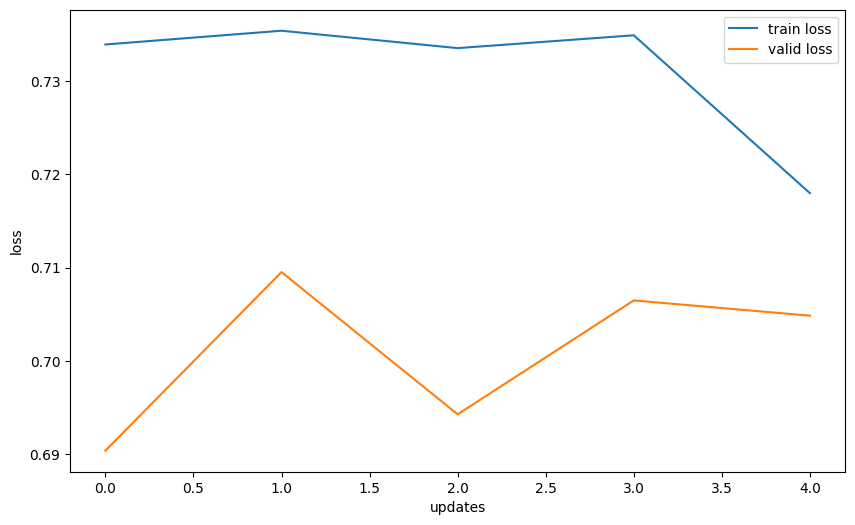

In [51]:
##Plot the losses and accuracy over all epochs
##Plot the training loss and the accuracy
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

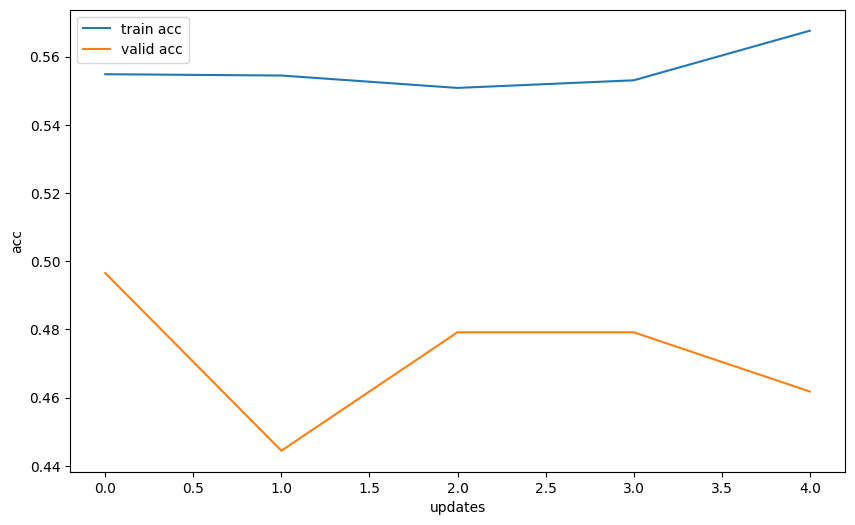

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

## Conclusion
1. Compare the two models on their time and accuracy. Which one do you think did well for the disaster classification task. and Why?

- Answer : 

| Model      | Train Loss | Train Acc | Val Loss | Val Acc | Time |
| :-----------: | :-----------: | :-----------: | :-----------: | :-----------: | :-----------: |
| CNN      | 0.738       | 54.64%       | 0.691       | 48.78%       | 11s       |
| biLSTM   | 0.718        | 56.76%        | 0.705        | 46.18%        | 10s        |

The CNN model performed slightly better in terms of validation loss and accuracy with 5 epochs. The training time only took 10% longer than the biLSTM model. Thus, I believe the <b>CNN model</b> did better for the disater classification task. The reason being that the contextual information captured by the CNN model better represented the data given.

2. How do you think we get better results in this dataset for classification.

- Answer : Looking the trend in the loss and accuracy graphs, we can see with the CNN model that the loss is still going down and the accuracy graph shows that it is going up. As such I believe <b>increasing the number of epochs</b> would get us better results for this dataset.

